# Lab 2: Supervised Learning

In this lab, we prepare our Kiva data for a linear regression, and run linear regressions that attempt to answer as question we may have as Kiva borrowers: 

  *How much should I ask for on Kiva? *

In the language of Module 1, our outcome feature is: 

    loan_amount

We will try using and evaluating different explanatory features in this notebook. 

But first, we will load the packages we need for this section, and our data. As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Notebook 1, we merged these data files and created new variables to form the data frame "df", which we will use now. **If you haven't already, please run through Notebook 1!**  

In [1]:
## Import packages

import pandas as pd
import numpy as np
from datetime import datetime
from ggplot import *
%matplotlib inline

# packages for checking assumptions
from scipy import stats as stats

# packages for linear regression and validation 
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [58]:
## Read in data

##data_path = '~/intro_to_machine_learning/data'
data_path = '~/Desktop'
df = pd.read_csv(data_path+'/df.csv', low_memory=False)

## Creating Explanatory Features of Interest

   ### Demographics

Since we are interested in using the demographics of the Kiva borrowers as potential explanatory features, we will create, clean, and otherwise prepare these for linear regression. We are using a new method: str.contains. You may remember the method np.where from Notebook 1. 

In [59]:
## Whether or not the borrower is widowed
#  Note the str.contains function
df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=0) ==True, 1, 0)

## Whether or not the borrower has children 
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter", na=0) ==True,1,0)

In creating the "widowed" and "kids" feature, we are using Numpy's [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function  and Panda's [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html) to filter the data such that we are only creating a Boolean variable for those observations in which we find the strings of interest - in this case, any variation of the words widow, and any indication of children. Note that we try to be inclusive by testing for variations like "daughter" and "son."

### Loan features

Next we create features related to the conditions surrounding each loan posting, including: 
1. Whether or not a borrower has included a video or a picture: 
    1. Here, our intuition tells us that if a borrower includes more personal details and imagery, lenders are more likely to lend to them. We create this variable so we can differentiate between loans that have these personal details and loans that do not.   
2. The time it takes loans to get their first repayment  

In [60]:
## Features of the loan posting

## Does the borrower include a video? 
df['video'] = np.where(pd.isnull(df['video.id']) ==False, 1, 0)

## Does the borrower include a picture? 
df['pictured'] = np.where(pd.isnull(df['image.id']) ==False, True, False)

In order to get information on time, we first need to make sure that the data is in Python's datetime format. Once all relevant features are converted to this format, we can perform operations on them. In this case, we want to find out how many days elapsed between two dates, so we subtract the earlier date from the later date and report the output in days. 

As we saw in Module 1, we already ensured our date features are converted to datetime format using the `to_datetime` function. However, in reading in our "df" csv file, Python forgot the Pandas format we assigned. Therefore we convert our created variables to datetime format again. We then create a day feature from each of the datetime differences we calculate.

In [61]:
## Ensuring datetime format
df['planned_expiration_datetime'] = pd.to_datetime(df['planned_expiration_datetime'])
df['posted_datetime'] = pd.to_datetime(df['posted_datetime'])

## Time to expiration is the expiration date minus the Posted Date
df['time_to_expire_datetime'] =df['planned_expiration_datetime'] - df['posted_datetime']
df['days_to_expire'] = df.time_to_expire_datetime.dt.days

## Checking Assumptions

### Normality
In Module 2, we reviewed that normal distribution of variables is an assumption underlying linear regression. Let's look first at our dependent variable, loan_amounts.

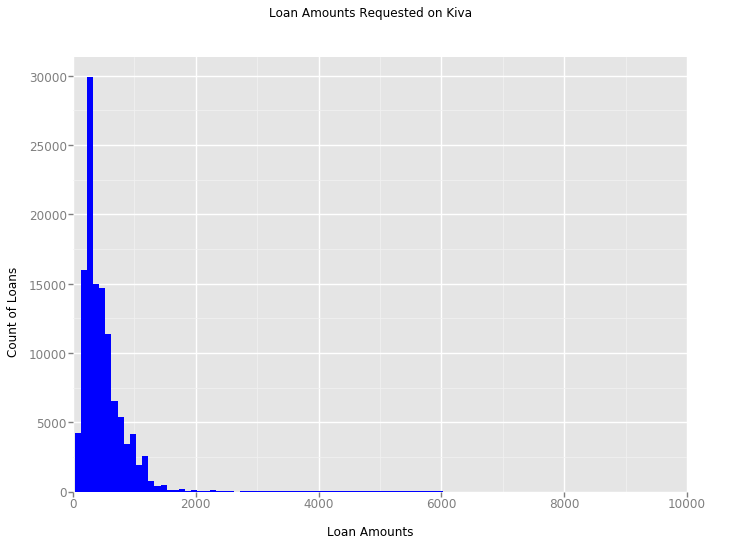

<ggplot: (-9223371931826182291)>

In [6]:
ggplot(df, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 10000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

This data looks pretty skewed to the left, towards values of $25, which we know is the minimum Kiva asks from lenders. 

We can also do a more statistical test of skewness. [Scipy's stats package](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.skew.html) allows you to conduct a skew test. A normally distributed dataset would return about 0. A skewness value of greater than 0 means there is more in the left tail fo the distribution. Typically, a skew score of +-1 is deemed acceptable.

In [7]:
print(stats.skew(df.loan_amount, axis=None))

33.89270408065896


This confirms our suspicion that the data is skewed to the left. How can we fix this? 

One potential solution is to **log transform** your data. For a quick review of logarithms, look [here](https://www.mathsisfun.com/algebra/logarithms.html). 

Note that when we log transform data, we change our interpretation of the final regression output. Previously we had a simple linear equation... 

    y = mx + b

This could be interpreted as, with every unit increase in x, we get a m increase in outcome feature y. Now we have a log equation: 

    log(y) = mx + b
    
This is less intuitive, as we have to solve for y. When we solve for y through exponentiation, we get the following equation: 

    y = 10^(mx + b)
    y = 10^(mx) * 10^(b)

The default base for log is 10. The takeaway here is that the impact x would have on y is much larger than linear - it is **exponentiated**. We will return to this interpretation in the discussion of the linear regression model. Let's try log transforming our loan_amount variable. 

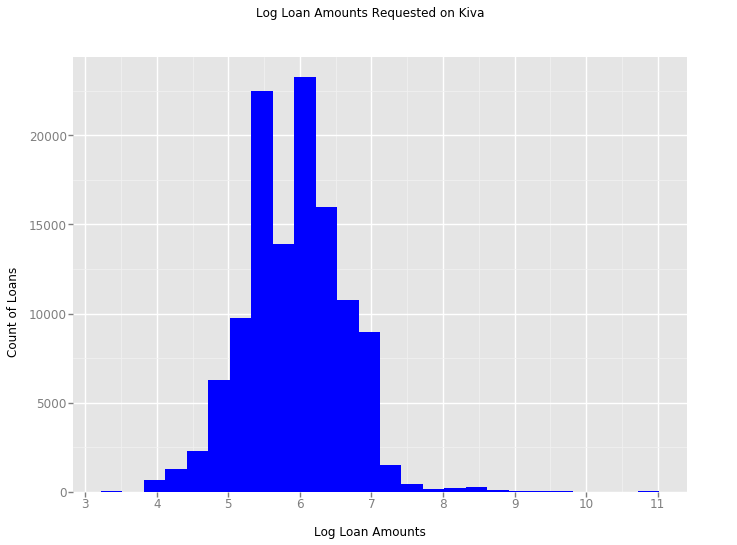

<ggplot: (-9223371931826333345)>

In [62]:
df['log_loan_amount'] = np.log(df['loan_amount'])

ggplot(df, aes(x='log_loan_amount')) + geom_histogram(binwidth=0.3, fill="blue") + \
ggtitle("Log Loan Amounts Requested on Kiva") + xlab("Log Loan Amounts") + ylab("Count of Loans")

In [9]:
print(stats.skew(df['log_loan_amount']))

0.14839961560072792


Great! This looks much closer to normal, both in the chart and in our skew statistic.

Let's turn now to checking our other assumptions.

### Check for multicollinearity

Numpy's Corrcoef function returns a matrix of Pearson correlation coefficients. To recap Module 2's lesson, multicollinearity is a problem when we have highly correlated explanatory features, as this makes it difficult for the model to try to differentitae between each feature's influence on the explanatory feature. Read more about Numpy's Corrcoef [here](https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.corrcoef.html).

Try running different features!

In [10]:
np.corrcoef(df.loan_amount, df.funded_amount)

array([[ 1.        ,  0.97333343],
       [ 0.97333343,  1.        ]])

This tells us that loan amount and funded amount are extremely highly correlated - a vast majority of loans requested get funded! Normally, we would be interested in both loan_amount and funded_amount as an outcome feature, but here we see that it would be redundant to test both. 

It would take a long time for us to test each and every relationship between two sets of variables, so let's create a correlation matrix that lets us visualize every correlation in a dataset using Pandas.

In [12]:
df_corr_tbl = df[['funded_amount', 'loan_amount', 'log_loan_amount', 'lender_count', 'borrower_count', 'gender', 'widowed', 'kids', 'video', 'pictured', 'days_to_expire']]
df_corr_tbl.corr()

,funded_amount,loan_amount,log_loan_amount,lender_count,borrower_count,widowed,kids,video,pictured,days_to_expire
funded_amount,1.000000,0.973333,0.569338,0.966091,0.199865,-0.016536,-0.036267,0.138491,NaN,0.082532
loan_amount,0.973333,1.000000,0.592568,0.936628,0.217043,-0.019917,-0.030220,0.132316,NaN,0.084827
log_loan_amount,0.569338,0.592568,1.000000,0.558347,0.359565,-0.033945,-0.040790,0.004814,NaN,0.076844
lender_count,0.966091,0.936628,0.558347,1.000000,0.182836,-0.014063,-0.031407,0.129759,NaN,0.081412
borrower_count,0.199865,0.217043,0.359565,0.182836,1.000000,-0.042936,0.065381,-0.005363,NaN,0.019546
widowed,-0.016536,-0.019917,-0.033945,-0.014063,-0.042936,1.000000,0.046876,0.009926,NaN,0.015540
kids,-0.036267,-0.030220,-0.040790,-0.031407,0.065381,0.046876,1.000000,-0.000634,NaN,-0.027457
video,0.138491,0.132316,0.004814,0.129759,-0.005363,0.009926,-0.000634,1.000000,NaN,0.016898
pictured,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
days_to_expire,0.082532,0.084827,0.076844,0.081412,0.019546,0.015540,-0.027457,0.016898,NaN,1.000000


Of course, not every correlation in this table will be meaningful. A correlation table is useful as it provides a visual shortcut to see what relationships might be problematic for multicollinearity. 

## Linear Regression

Now we're relatively confident about what our data looks like, let's try some regressions. We will focus in on outcome features time_to_disburse and loan_amount. We encourage you to explore other outcome features!  

As discussed in Module 2, we will divide the data into training and test sets so we can validate our regression results.

Note that training set should be larger than the test set, as we should train our model on as much data as possible. For this example, we divide the data 80% training / 20% test.

In [63]:
# Set training-test split %
split_pct = 0.80

# Remove null and NaN values 
df_cln = df[pd.notnull(df)]

# the pandas command "sample" already randomizes its selection. 
loans_full_shuffled = df_cln.sample(frac=1)

train_set = loans_full_shuffled[:int((len(loans_full_shuffled)+1*split_pct))] 
test_set = loans_full_shuffled[int(len(loans_full_shuffled)*split_pct+1):]  

Now we have two separate datasets: train_set and test_set. We will run the regression on train_set
using statsmodel's "ols" function. Let's try a simple example to start: 

In [14]:
model0 = sm.ols(formula="loan_amount ~ gender", data=train_set).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     464.3
Date:                Sun, 28 May 2017   Prob (F-statistic):          8.62e-103
Time:                        11:23:01   Log-Likelihood:            -9.4344e+05
No. Observations:              118316   AIC:                         1.887e+06
Df Residuals:                  118314   BIC:                         1.887e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept        463.9520      2.504    185.

This is the typical regression output. It's a lot to digest! Remember that our simple model can be represented as a linear equation, like this: 

    loan_amount = intercept + coef*male

Therefore, these results can be translated as follows: 

    loan_amount = 463.9520 + 93.3054*male

Noticeably, the coefficient for male is not small, suggesting that whether or not a borrower is male **does** influence loan_amount. We have a sufficient amount of confidence in this conclusion because the **p-value** is reported to be 0.000. In technical terms, the p-value is **the probability of getting results as extreme as the ones observed. **

In statistics, we want our results to fall within the 95% confidence interval, or the p-value to be <= 0.05. This means, "[i]f repeated samples were taken and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the population mean. A 95% confidence interval has a 0.95 probability of containing the population mean. 95% of the population distribution is contained in the confidence interval." [Read more here.](http://www.investopedia.com/terms/s/standard-error.asp) The p-value is an indicator of where we fall in the confidence interval. In English, small p-value (<= 0.05) indicates strong evidence that the coefficient is different than 0. 

This is a relatively simplified explanation of p-values. Don't worry if it's not immediately intuitive - [not even professional statisticians can easily explain this concept.](http://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) To get a deeper understanding, we recommend grabbing the nearest textbook on statistics to review! 

Note also that the Adjusted R Squared is extremely low. To recap lessons from Module 2, the Adjusted R Squared is an explanation of how much of the outcome feature can be explained by the model's explanatory features. This low Adj R Squared suggests that the predictive value of male is pretty low - it cannot be used as the single feature to predict loan_amount. 

This result is in line with our understanding of the world - there must be other factors influencing loan_amount. Let's try complicating the model by adding more explanatory features. 

#### Model 1

In [67]:
train_set = train_set.rename(columns={'terms.repayment_term': 'repayment_term'})
test_set = test_set.rename(columns={'terms.repayment_term': 'repayment_term'})

In [17]:
model1 = sm.ols(formula="log_loan_amount ~ borrower_count + sector + kids + gender + widowed + pictured + video + days_to_expire + repayment_term", data=train_set)
model1_results = model1.fit()
print(model1_results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_loan_amount   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     1895.
Date:                Sun, 28 May 2017   Prob (F-statistic):               0.00
Time:                        11:23:35   Log-Likelihood:                -81853.
No. Observations:               93403   AIC:                         1.637e+05
Df Residuals:                   93381   BIC:                         1.640e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

This **multi-feature** (or multivariate) model is more aligned with our understanding of the world. We see that adding a picture to your profile increases the amount that you might ask for. We also see that males tend to get larger loans, and widows and those with children tend to get slightly smaller loans. Most coefficients have very low p-values - a good sign! 

Our Adjusted R Squared is higher than it was in the single-feature model. Let's get into how we evaluate the model in terms of predictiveness. 

## Model Validation

<i>How can we evaluate how our model is doing? </i>

In the previous section, we were able to get general ideas of how well our model was doing by using metrics like Adjusted R Squared, coefficients, and p-value. However, the goal of most machine learning is a model that can <b>predict outcome features accurately</b>. Recall that we randomly split our dataset into a training set (80%) and a test set (20%). Now we will use the results from the regression conducted on our training set to predict the outcome features for each observation in our test set. The difference between the predicted outcome feature and the actual outcome feature for each observation gives us an idea of how close we are to the mark.  

In the previous section, we used the **statsmodel** package in order to output a regression output table. Now, we run the regression using the **scikit-learn** package, which is optimized specifically for machine learning and allows us to validate our models easily. Remember this package - we will be returning to it for the rest of the class!  

#### Validation of Model 1:

In [64]:
#Pre Processing

# Split the outcome and explanatory features into training/testing sets 
#  using our already-made training and test datasets
train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)
train_set_y = train_set['log_loan_amount']
test_set_y = test_set['log_loan_amount']

# Process categorical variable "Gender" into individual Boolean features. 
#  Since there are only two possible values, we can keep this short. 
train_set['gender_dummy'] = train_set['gender']=="Male"
test_set['gender_dummy'] = test_set['gender']=="Male"

# Process categorical variable "Sector" into individual Boolean features 
#  Since there are 15 different sectors, this requires more processing.

# Encode categorical variable 'sector' into numeric 
le = preprocessing.LabelEncoder()
le.fit(train_set['sector'])

# create array of sectors as numbers 
sector_as_num = le.transform(train_set['sector']).reshape(-1,1)

# One-hot encode sectors of loans so that each sector has its own Boolean column (statsmodel does this automatically)
enc = OneHotEncoder()
enc.fit(sector_as_num)
# Create array of columns
sector_dummies = enc.transform(sector_as_num).toarray()
sector_dummies = pd.DataFrame(sector_dummies, columns = ["dummy_"+str(i) for i in range(1,16)])
# Join array of boolean columns with original training set 
train_set = pd.concat([train_set, sector_dummies], axis=1)
test_set = pd.concat([test_set, sector_dummies], axis=1)

In [68]:
train_set_x = train_set[['borrower_count', 'kids', 'gender_dummy', 'widowed', 'pictured', 'video', \
                         'days_to_expire', 'repayment_term',
                         'dummy_1', 'dummy_2', 'dummy_3', 'dummy_4', 'dummy_5', 'dummy_6',\
                         'dummy_7','dummy_8','dummy_9','dummy_10','dummy_11','dummy_12','dummy_13',\
                         'dummy_14','dummy_15']]
test_set_x = test_set[['borrower_count', 'kids', 'gender_dummy', 'widowed', 'pictured', 'video', \
                        'days_to_expire', 'repayment_term',
                      'dummy_1', 'dummy_2', 'dummy_3', 'dummy_4', 'dummy_5', 'dummy_6', \
                       'dummy_7','dummy_8','dummy_9','dummy_10','dummy_11','dummy_12','dummy_13',\
                       'dummy_14','dummy_15']]

To pre-process, we separate our big dataset into specific segments: Explanatory Features and Outcome Features. For each set of features, we have a Test Set and a Training Set. 

In [76]:
# Linear Regression

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
model1 = regr.fit(train_set_x, train_set_y)
print(model1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(test_set_x) - test_set_y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(test_set_x, test_set_y))

In this snippet, we run the linear regression and output the MSE, Explained variance score, and coefficients. Scikit learn's output is a little less intuitively laid out than the statsmodel output, but the outputs should match. 

Now let's try to predict the test or "holdout" set using the output from the training set. 

In [42]:
y_pred = model1.predict(test_set_x)
y_true = test_set_y

y_pred

ValueError: shapes (93403,23) and (118316,38) not aligned: 23 (dim 1) != 118316 (dim 0)

##  DEV NOTE add'l commentary here

Now we calculate statistics intended to shed light on how well these predicted values reflect the actual values of the outcome features. 

In [ ]:
## Explained mean absolute error
mean_absolute_error(y_true, y_pred)

Explained mean absolute error is "a quantity used to measure how close forecasts or predictions are to the eventual outcomes." Read more [here.](https://www.kaggle.com/wiki/MeanAbsoluteError). 

In [ ]:
## Explained mean square error
mean_squared_error(y_true, y_pred)

Explained mean squared error is .... 